In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import fancyimpute

from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsemble

from mlens.visualization import corrmat
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer as Imputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (roc_auc_score, confusion_matrix,
                             accuracy_score, roc_curve,
                             precision_recall_curve, f1_score)
from sklearn.pipeline import make_pipeline

import xgboost as xgb
from keras import models, layers, optimizers

Using TensorFlow backend.
[MLENS] backend: threading


## Hal pertama yang perlu dilakukan adalah memuat dataset, lalu mengecek tipe data dari setiap fitur. Setelah itu perlu diperhatikan apakah terdapat missing value.

# 1. Load Datasets
### Load train data and check if data has missing value

In [2]:
# Load the data train
sentinels = {'ORGANIZATION_TYPE': ['NA1']}
df = pd.read_csv("datasets/app_train.csv", na_values=sentinels)

print(f"{df.dtypes}\n")
print(f"Sum of null values in each feature:\n{35 * '-'}")
print(f"{df.isnull().sum()}")
df.head()

Unnamed: 0             int64
LN_ID                  int64
TARGET                 int64
CONTRACT_TYPE         object
GENDER                object
NUM_CHILDREN           int64
INCOME               float64
APPROVED_CREDIT      float64
ANNUITY              float64
PRICE                float64
INCOME_TYPE           object
EDUCATION             object
FAMILY_STATUS         object
HOUSING_TYPE          object
DAYS_AGE               int64
DAYS_WORK              int64
DAYS_REGISTRATION    float64
DAYS_ID_CHANGE         int64
WEEKDAYS_APPLY        object
HOUR_APPLY             int64
ORGANIZATION_TYPE     object
EXT_SCORE_1          float64
EXT_SCORE_2          float64
EXT_SCORE_3          float64
dtype: object

Sum of null values in each feature:
-----------------------------------
Unnamed: 0               0
LN_ID                    0
TARGET                   0
CONTRACT_TYPE            0
GENDER                   0
NUM_CHILDREN             0
INCOME                   0
APPROVED_CREDIT          0
A

Unnamed: 0   LN_ID  TARGET    CONTRACT_TYPE GENDER  NUM_CHILDREN    INCOME  \
0      201468  333538       0  Revolving loans      F             1   67500.0   
1      264803  406644       0       Cash loans      F             1  202500.0   
2      137208  259130       0       Cash loans      F             0  180000.0   
3      269220  411997       0       Cash loans      M             0  225000.0   
4      122096  241559       0  Revolving loans      M             0  135000.0   

   APPROVED_CREDIT  ANNUITY     PRICE     ...      DAYS_AGE DAYS_WORK  \
0         202500.0  10125.0  202500.0     ...        -11539      -921   
1         976711.5  49869.0  873000.0     ...        -15743     -4482   
2         407520.0  25060.5  360000.0     ...        -20775    365243   
3         808650.0  26086.5  675000.0     ...        -20659    -10455   
4         180000.0   9000.0  180000.0     ...         -9013     -1190   

  DAYS_REGISTRATION DAYS_ID_CHANGE  WEEKDAYS_APPLY  HOUR_APPLY  \
0            -119.0          -2757         TUESDAY          18   
1           -1797.0          -2455         TUESDAY          14   
2           -8737.0          -4312        THURSDAY          14   
3           -4998.0          -4010       WEDNESDAY          10   
4           -3524.0          -1644          SUNDAY          11   

        ORGANIZATION_TYPE  EXT_SCORE_1 EXT_SCORE_2  EXT_SCORE_3  
0  Business Entity Type 3     0.572805    0.608276          NaN  
1                   Other     0.655600    0.684298          NaN  
2                     NaN          NaN    0.580687     0.749022  
3                 Culture          NaN    0.623740     0.710674  
4            Construction     0.175511    0.492994     0.085595  

[5 rows x 24 columns]

### Load test data

In [3]:
# Load the data test
df_test = pd.read_csv("datasets/app_test.csv", na_values=sentinels)
df_test.head()

Unnamed: 0   LN_ID  TARGET CONTRACT_TYPE GENDER  NUM_CHILDREN    INCOME  \
0      102590  219092       0    Cash loans      M             3  135000.0   
1       35895  141577       0    Cash loans      F             0  144000.0   
2       69154  180205       0    Cash loans      F             1   90000.0   
3      222185  357381       0    Cash loans      M             2  112500.0   
4      147680  271229       0    Cash loans      M             0  216000.0   

   APPROVED_CREDIT  ANNUITY     PRICE     ...      DAYS_AGE DAYS_WORK  \
0         871029.0  44604.0  765000.0     ...        -17598     -2650   
1         485640.0  34537.5  450000.0     ...        -14097     -7408   
2         247500.0   8887.5  247500.0     ...        -18384     -2826   
3         506889.0  24781.5  418500.0     ...        -12170      -926   
4         450000.0  21888.0  450000.0     ...        -10790      -577   

  DAYS_REGISTRATION DAYS_ID_CHANGE  WEEKDAYS_APPLY  HOUR_APPLY  \
0           -1411.0          -1131        SATURDAY           7   
1           -7908.0          -4872          MONDAY          14   
2           -8226.0          -1930        SATURDAY          12   
3            -916.0          -4048        THURSDAY          13   
4           -4640.0          -2035          MONDAY          14   

        ORGANIZATION_TYPE  EXT_SCORE_1 EXT_SCORE_2  EXT_SCORE_3  
0  Business Entity Type 3          NaN    0.145475     0.651260  
1            Kindergarten          NaN    0.682675          NaN  
2           Self-employed     0.814700    0.686312     0.758393  
3                   Other     0.399219    0.266520     0.058826  
4  Business Entity Type 3     0.368452    0.610483     0.392774  

[5 rows x 24 columns]

 ## Kita juga perlu memperhatikan apakah dataset tersebut balance atau tidak.

Positive examples = 4969
Negative examples = 56534
Proportion of positive to negative examples = 8.79%


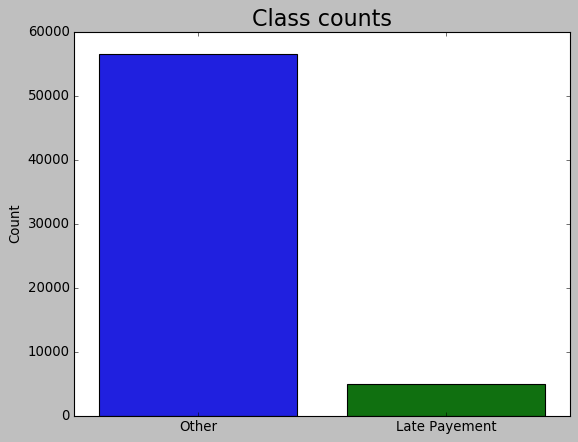

In [4]:
import matplotlib.style
import matplotlib.pyplot as plt
plt.style.use('classic')

# Get number of positve and negative examples
pos = df[df["TARGET"] == 1].shape[0]
neg = df[df["TARGET"] == 0].shape[0]
print(f"Positive examples = {pos}")
print(f"Negative examples = {neg}")
print(f"Proportion of positive to negative examples = {(pos / neg) * 100:.2f}%")
plt.figure(figsize=(8, 6))
sns.countplot(df["TARGET"])
plt.xticks((0, 1), ["Other", "Late Payement"])
plt.xlabel("")
plt.ylabel("Count")
plt.title("Class counts", y=1, fontdict={"fontsize": 20});

In [5]:
df.head()

Unnamed: 0   LN_ID  TARGET    CONTRACT_TYPE GENDER  NUM_CHILDREN    INCOME  \
0      201468  333538       0  Revolving loans      F             1   67500.0   
1      264803  406644       0       Cash loans      F             1  202500.0   
2      137208  259130       0       Cash loans      F             0  180000.0   
3      269220  411997       0       Cash loans      M             0  225000.0   
4      122096  241559       0  Revolving loans      M             0  135000.0   

   APPROVED_CREDIT  ANNUITY     PRICE     ...      DAYS_AGE DAYS_WORK  \
0         202500.0  10125.0  202500.0     ...        -11539      -921   
1         976711.5  49869.0  873000.0     ...        -15743     -4482   
2         407520.0  25060.5  360000.0     ...        -20775    365243   
3         808650.0  26086.5  675000.0     ...        -20659    -10455   
4         180000.0   9000.0  180000.0     ...         -9013     -1190   

  DAYS_REGISTRATION DAYS_ID_CHANGE  WEEKDAYS_APPLY  HOUR_APPLY  \
0            -119.0          -2757         TUESDAY          18   
1           -1797.0          -2455         TUESDAY          14   
2           -8737.0          -4312        THURSDAY          14   
3           -4998.0          -4010       WEDNESDAY          10   
4           -3524.0          -1644          SUNDAY          11   

        ORGANIZATION_TYPE  EXT_SCORE_1 EXT_SCORE_2  EXT_SCORE_3  
0  Business Entity Type 3     0.572805    0.608276          NaN  
1                   Other     0.655600    0.684298          NaN  
2                     NaN          NaN    0.580687     0.749022  
3                 Culture          NaN    0.623740     0.710674  
4            Construction     0.175511    0.492994     0.085595  

[5 rows x 24 columns]

## Setelah melakukan pengecekan ternyata dataset memiliki missing value pada 6 fitur. Juga dataset sangat tidak ballance, dimana data positif hanya 8.79%. Namun sebelum mengatasi hal tersebut, kita perlu malakukan encoding pada fitur kategorikal.

# 2. Preproses Data

### Tahap-tahap praproses data akan dilakukan sebagai berikut:
1. Melakukan encoding pada data-data kategorikal, karena data kategorikal yang ada merupakan nominal maka kita perlu membuat variabel dummy.
2. Membagi data train menjadi training set dan test set. Data teserbut akan dibagi dengan perbandingan 80% training set dan 20% test set. Data ini akan kita gunakan dalam 10-fold cross validation.
3. Standarisasi data menggunakan RobustScaler. Hal ini dilakukan untuk membuat data lebih dekat dengan nilai median dan lalu di-scale menggunakan interquatile range(IQR).

### Data Train

In [6]:
# Create dummy variables from the feature purpose
df_dummies = pd.get_dummies(df, columns=["CONTRACT_TYPE","GENDER"], drop_first=True)
df_dummies = pd.get_dummies(df_dummies, columns=["INCOME_TYPE","EDUCATION","FAMILY_STATUS","HOUSING_TYPE","ORGANIZATION_TYPE"])

#not sure for feature WEEKDAYS_APPLY(encode to numerical or categorical)
df_dummies = pd.get_dummies(df_dummies, columns=["WEEKDAYS_APPLY"])

df_dummies = df_dummies.drop([df_dummies.columns[0],df_dummies.columns[1]], axis=1)

### Data Test

In [7]:
# Create dummy variables from the feature purpose
df_test_dummies = pd.get_dummies(df_test, columns=["CONTRACT_TYPE","GENDER"], drop_first=True)
df_test_dummies = pd.get_dummies(df_test_dummies, columns=["INCOME_TYPE","EDUCATION","FAMILY_STATUS","HOUSING_TYPE","ORGANIZATION_TYPE"])

#not sure for feature WEEKDAYS_APPLY(encode to numerical or categorical)
df_test_dummies = pd.get_dummies(df_test_dummies, columns=["WEEKDAYS_APPLY"])

df_test_dummies = df_test_dummies.drop([df_test_dummies.columns[0],df_test_dummies.columns[1]], axis=1)

In [8]:
df_dummies.head()

TARGET  NUM_CHILDREN    INCOME  APPROVED_CREDIT  ANNUITY     PRICE  \
0       0             1   67500.0         202500.0  10125.0  202500.0   
1       0             1  202500.0         976711.5  49869.0  873000.0   
2       0             0  180000.0         407520.0  25060.5  360000.0   
3       0             0  225000.0         808650.0  26086.5  675000.0   
4       0             0  135000.0         180000.0   9000.0  180000.0   

   DAYS_AGE  DAYS_WORK  DAYS_REGISTRATION  DAYS_ID_CHANGE  \
0    -11539       -921             -119.0           -2757   
1    -15743      -4482            -1797.0           -2455   
2    -20775     365243            -8737.0           -4312   
3    -20659     -10455            -4998.0           -4010   
4     -9013      -1190            -3524.0           -1644   

             ...             ORGANIZATION_TYPE_Transport: type 3  \
0            ...                                               0   
1            ...                                               0   
2            ...                                               0   
3            ...                                               0   
4            ...                                               0   

   ORGANIZATION_TYPE_Transport: type 4  ORGANIZATION_TYPE_University  \
0                                    0                             0   
1                                    0                             0   
2                                    0                             0   
3                                    0                             0   
4                                    0                             0   

   WEEKDAYS_APPLY_FRIDAY  WEEKDAYS_APPLY_MONDAY  WEEKDAYS_APPLY_SATURDAY  \
0                      0                      0                        0   
1                      0                      0                        0   
2                      0                      0                        0   
3                      0                      0                        0   
4                      0                      0                        0   

   WEEKDAYS_APPLY_SUNDAY  WEEKDAYS_APPLY_THURSDAY  WEEKDAYS_APPLY_TUESDAY  \
0                      0                        0                       1   
1                      0                        0                       1   
2                      0                        1                       0   
3                      0                        0                       0   
4                      1                        0                       0   

   WEEKDAYS_APPLY_WEDNESDAY  
0                         0  
1                         0  
2                         0  
3                         1  
4                         0  

[5 rows x 103 columns]

### Strategi untuk mengatasi missing value
Pada data yang kita gunakan terdapat 6 fitur yang memiliki missing value, namun salah satunya data kategorikal. Dikarenakan terkadang missing value memiliki informasi penting dan tidak dibuat secara acak, maka kita akan membuat fitur biner dari fitur yang memiliki missing value tersebut. Misal, fitur "Price" memiliki missing value maka akan dibuat fitur biner "is_Price_missing" yang memiliki nilai 1 atau 0. Selain itu kita juga akan melakukan beberapa metode untuk mengatasi missing value, seperti:
1. Menghapus data yang memiliki missing value.
2. Impute missing value dengan nilai mean dari setiap fitur.
3. Impute missing value dengan nilai median dari setiap fitur.

### Data Train

In [9]:
# Create binary features to check if the example is has missing values for all features that have missing values
for feature in df_dummies.columns:
    if np.any(np.isnan(df_dummies[feature])):
        df_dummies["is_" + feature + "_missing"] = np.isnan(df_dummies[feature]) * 1

# Original Data
X = df_dummies.loc[:, df_dummies.columns != "TARGET"].values
y = df_dummies.loc[:, df_dummies.columns == "TARGET"].values.flatten()
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)
print(f"Original data shapes: {X_train.shape, X_test.shape}")

Original data shapes: ((49202, 107), (12301, 107))


In [10]:
# Drop NA and remove binary columns
train_indices_na = np.max(np.isnan(X_train), axis=1)
test_indices_na = np.max(np.isnan(X_test), axis=1)
X_train_dropna, y_train_dropna = X_train[~train_indices_na, :][:, :-6], y_train[~train_indices_na]
X_test_dropna, y_test_dropna = X_test[~test_indices_na, :][:, :-6], y_test[~test_indices_na]
print(f"After dropping NAs: {X_train_dropna.shape, X_test_dropna.shape}")

After dropping NAs: ((17332, 101), (4457, 101))


In [11]:
# Build random forest classifier
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_features=0.25,
                                criterion="entropy",
                                class_weight="balanced")
# Build base line model -- Drop NA's
pip_baseline = make_pipeline(RobustScaler(), rf_clf)
scores = cross_val_score(pip_baseline,
                         X_train_dropna, y_train_dropna,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mBaseline model's average AUC: {scores.mean():.3f}")

# Build model with mean imputation
pip_impute_mean = make_pipeline(Imputer(strategy="mean"),
                                RobustScaler(), rf_clf)
scores = cross_val_score(pip_impute_mean,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mMean imputation model's average AUC: {scores.mean():.3f}")

# Build model with median imputation
pip_impute_median = make_pipeline(Imputer(strategy="median"),
                                  RobustScaler(), rf_clf)
scores = cross_val_score(pip_impute_median,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mMedian imputation model's average AUC: {scores.mean():.3f}")

Baseline model's average AUC: 0.750
Mean imputation model's average AUC: 0.735
Median imputation model's average AUC: 0.736


In [12]:
# fit RF to plot feature importances
rf_clf.fit(RobustScaler().fit_transform(Imputer(strategy="median").fit_transform(X_train)), y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features=0.25,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

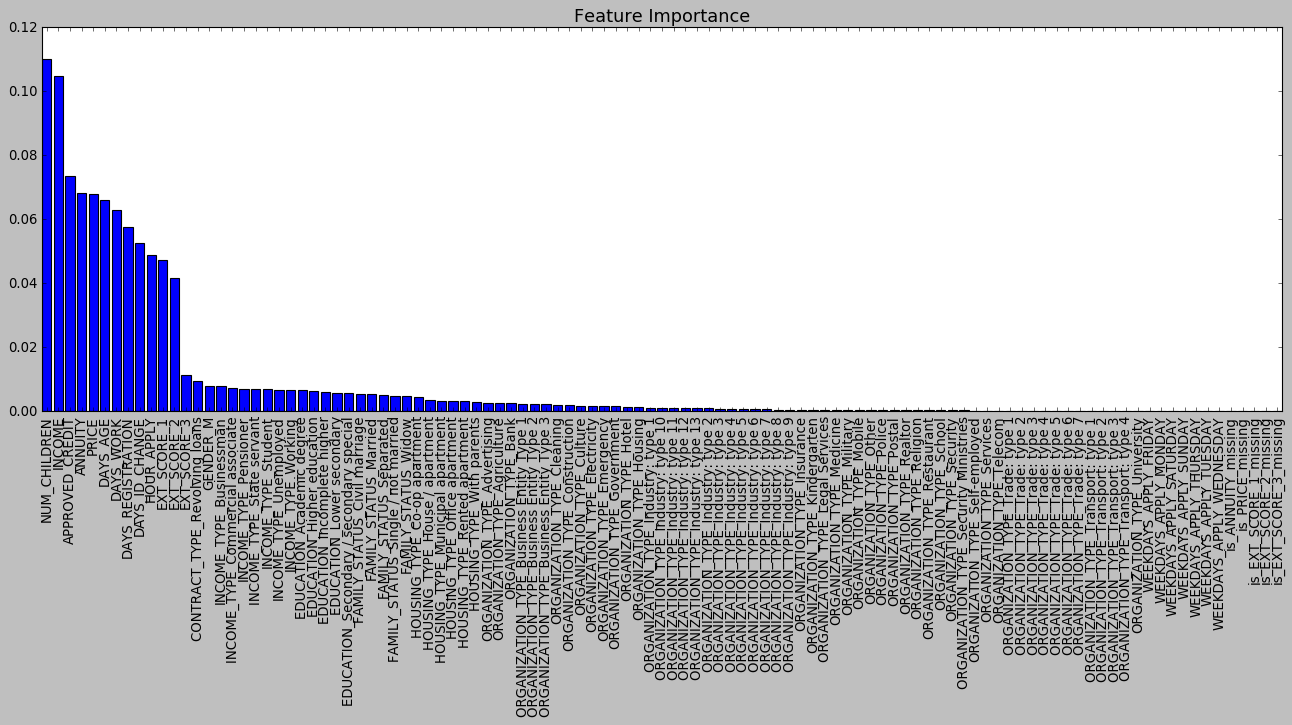

In [13]:
# Plot features importance
importances = rf_clf.feature_importances_
indices = np.argsort(rf_clf.feature_importances_)[::-1]
data_top = df_dummies.columns.values[1:]
plt.figure(figsize=(20, 6))
plt.bar(data_top, importances[indices], align="center")
plt.xticks(rotation=90)
plt.title("Feature Importance", {"fontsize": 16});

#### Dengan menggunakan AUC score pada 10-fold cross validation kita dapat membandingkan semua strategi untuk mengatasi missing value. Serta dapat disimpulkan bahwa missing value dibuat secara acak, maka fitur yang kita tambahkan sebelumnya tidak memiliki pengaruh pada klasifikasi Random Forest. Maka dari itu lebih baik kita abaikan. Serta untuk metode Median Imputation akan digunakan untuk mengatasi missing value kedepannya.

In [14]:
# Drop unecessary feature
X_train = X_train[:, :-12]
X_test = X_test[:, :-12]
print(f"Original data shapes: {X_train.shape, X_test.shape}")

Original data shapes: ((49202, 95), (12301, 95))


### Data Test

In [15]:
# Original Data
X_test_set = df_test_dummies.loc[:, df_test_dummies.columns != "TARGET"].values
y_test_set = df_test_dummies.loc[:, df_test_dummies.columns == "TARGET"].values.flatten()

# Drop unecessary feature
X_test_set = X_test_set[:, :-5]

print(f"Test data shapes: {X_test_set.shape, y_test_set.shape}")

Test data shapes: ((14761, 95), (14761,))


### Strategi untuk mengatasi Imbalanced Data
Pada kasus ini data positif hanya berjumlah sekitar 9% dari total data. Maka dari itu, akurasi tidak lagi menjadi acuan yang bagus untuk mengukur performa berbagai macam model, karena apabila kita memprediksi semua data sebagai data negatif kita akan mendapatkan akurasi sebesar 91%. Pengukuran yang lebih baik untuk data yang tidak balance adalah AUC(Area Under ROC Curve). Selain itu kita juga perlu melakukan sesuatu pada dataset untuk meningkatkan performa model. Terdapat beberapa metode untuk mengatasi data yang tidak balance, yaitu:
1. Under-Sample: metode ini akan mengurangi jumlah data yang major agar sama dengan jumlah data kelas minor.
2. Over-Sample: metode ini akan menambahkan data pada kelas minor agar sama dengan jumlah data kelas major.
3. Easy-Ensemble: metode ini mengambil beberapa sample dari kelas major lalu membuat klasifier dari data sampel tersebut, dan hasil dari semua classifier akan dikombinasikan.
4. Synthetic Minority Oversampling Technique (SMOTE): metode ini melakukan over-sample pada kelas minor namun dengan data buatan.

Dikarenakan dalam kasus ini lebih beresiko untuk melakukan kesalahan dalam mendeteksi kelas negatif(memberikan pinjaman pada applicant yang tidak layak), maka kita menggunakan class_weight yang mengubah bobot apabila terjadi kesalahan dalam mengklasifikasi data positif pada loss function. Serta kita akan mengevaluasi setiap metode dengan Random Forest.

In [16]:
# Build random forest classifier (same config)
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_features=0.25,
                                criterion="entropy",
                                class_weight="balanced")

# Build model with no sampling
pip_orig = make_pipeline(Imputer(strategy="mean"),
                         RobustScaler(),
                         rf_clf)
scores = cross_val_score(pip_orig,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mOriginal model's average AUC: {scores.mean():.3f}")

# Build model with undersampling
pip_undersample = imb_make_pipeline(Imputer(strategy="mean"),
                                    RobustScaler(),
                                    RandomUnderSampler(), rf_clf)
scores = cross_val_score(pip_undersample,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mUnder-sampled model's average AUC: {scores.mean():.3f}")

# Build model with oversampling
pip_oversample = imb_make_pipeline(Imputer(strategy="mean"),
                                    RobustScaler(),
                                    RandomOverSampler(), rf_clf)
scores = cross_val_score(pip_oversample,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mOver-sampled model's average AUC: {scores.mean():.3f}")

# Build model with EasyEnsemble
resampled_rf = BalancedBaggingClassifier(base_estimator=rf_clf,
                                         n_estimators=10, random_state=123)
pip_resampled = make_pipeline(Imputer(strategy="mean"),
                              RobustScaler(), resampled_rf)
                             
scores = cross_val_score(pip_resampled,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mEasyEnsemble model's average AUC: {scores.mean():.3f}")

# Build model with SMOTE
pip_smote = imb_make_pipeline(Imputer(strategy="mean"),
                              RobustScaler(),
                              SMOTE(), rf_clf)
scores = cross_val_score(pip_smote,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mSMOTE model's average AUC: {scores.mean():.3f}")

Original model's average AUC: 0.734
Under-sampled model's average AUC: 0.739
Over-sampled model's average AUC: 0.732
EasyEnsemble model's average AUC: 0.745
SMOTE model's average AUC: 0.703


Model EasyEnsemble mendapat nilai tertinggi pada 10-fold Cross Validation dengan rata-rata AUV=0.745

# 3. Model
Untuk melakukan klasifikasi kita akan menggunakan metode ensemble model. Ensemble model dibuat dengan menggabukan 3 model sebagai base learner, yaitu:
1. Extra Gradient Boosting
2. Support Vector Classifier
3. Random Forest

Hal ini dilakukan untuk mengurangi generalization error. Hal ini diasumsikan bahwa setiap model akan melihat aspek yang berbeda dari data. Pada kasus ini kita membuat ensemble model dengan 2 cara, yaitu blending ensemble model dan stacked ensemble model.

In [17]:
# Impute the missing data using features means
imp = Imputer()
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

# Standardize the data
std = RobustScaler()
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

# Implement RandomUnderSampler
random_undersampler = RandomUnderSampler()
X_res, y_res = random_undersampler.fit_sample(X_train, y_train)
# Shuffle the data
perms = np.random.permutation(X_res.shape[0])
X_res = X_res[perms]
y_res = y_res[perms]
X_res.shape, y_res.shape

((7950, 95), (7950,))

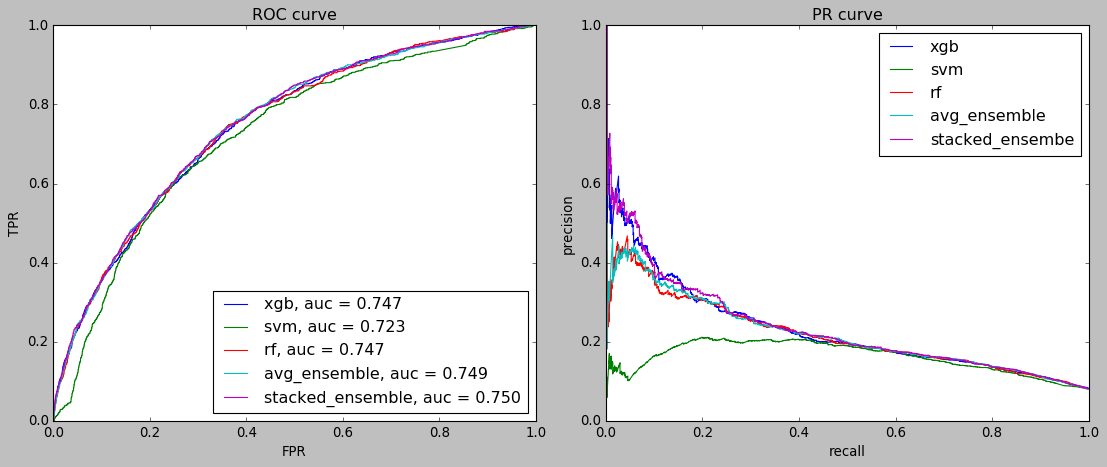

In [18]:
# Define base learners
xgb_clf = xgb.XGBClassifier(objective="binary:logistic",
                            learning_rate=0.03,
                            n_estimators=500,
                            max_depth=1,
                            subsample=0.4,
                            random_state=123)

svm_clf = SVC(gamma=0.1,
                C=0.01,
                kernel="poly",
                degree=3,
                coef0=10.0,
                probability=True)

rf_clf = RandomForestClassifier(n_estimators=300,
                                max_features="sqrt",
                                criterion="gini",
                                min_samples_leaf=5,
                                class_weight="balanced")

# Define meta-learner
logreg_clf = LogisticRegression(penalty="l2",
                                C=100,
                                fit_intercept=True)

# Fitting voting clf --> average ensemble
voting_clf = VotingClassifier([("xgb", xgb_clf),
                               ("svm", svm_clf),
                               ("rf", rf_clf)],
                              voting="soft",
                              flatten_transform=True)
voting_clf.fit(X_res, y_res)
xgb_model, svm_model, rf_model = voting_clf.estimators_
models = {"xgb": xgb_model, "svm": svm_model,
          "rf": rf_model, "avg_ensemble": voting_clf}

# Build first stack of base learners
first_stack = make_pipeline(voting_clf,
                            FunctionTransformer(lambda X: X[:, 1::2]))
# Use CV to generate meta-features
meta_features = cross_val_predict(first_stack,
                                  X_res, y_res,
                                  cv=10,
                                  method="transform")
# Refit the first stack on the full training set
first_stack.fit(X_res, y_res)
# Fit the meta learner
second_stack = logreg_clf.fit(meta_features, y_res)

# Plot ROC and PR curves using all models and test data
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for name, model in models.items():
            model_probs = model.predict_proba(X_test)[:, 1:]
            model_auc_score = roc_auc_score(y_test, model_probs)
            fpr, tpr, _ = roc_curve(y_test, model_probs)
            precision, recall, _ = precision_recall_curve(y_test, model_probs)
            axes[0].plot(fpr, tpr, label=f"{name}, auc = {model_auc_score:.3f}")
            axes[1].plot(recall, precision, label=f"{name}")
stacked_probs = second_stack.predict_proba(first_stack.transform(X_test))[:, 1:]
stacked_auc_score = roc_auc_score(y_test, stacked_probs)
fpr, tpr, _ = roc_curve(y_test, stacked_probs)
precision, recall, _ = precision_recall_curve(y_test, stacked_probs)
axes[0].plot(fpr, tpr, label=f"stacked_ensemble, auc = {stacked_auc_score:.3f}")
axes[1].plot(recall, precision, label="stacked_ensembe")
axes[0].legend(loc="lower right")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC curve")
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("PR curve")
plt.tight_layout()

Seperti yang ditunjukkan pada diagram diatas, bahwa stacked ensemble tidak meningkatkan performa. Hal ini dikarenakan base learner memiliki kolerasi yang tinggi terutama Random Forest and Gradient Boosting.

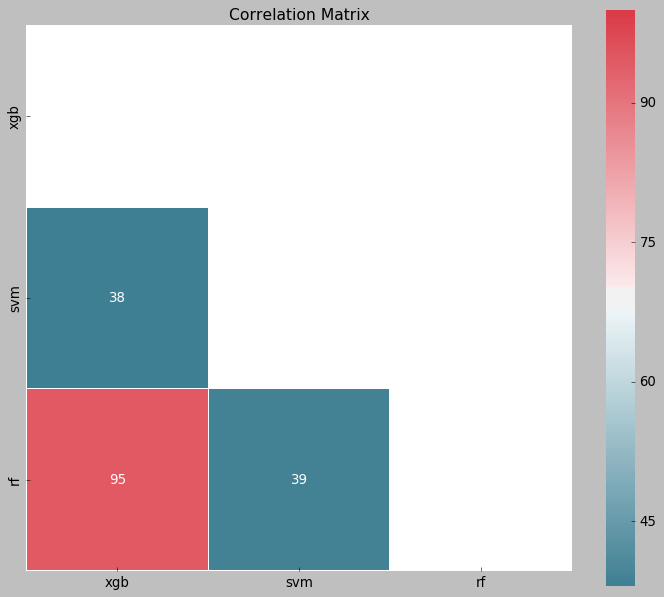

In [19]:
# Plot the correlation between base learners
probs_df = pd.DataFrame(meta_features, columns=["xgb", "svm", "rf"])
corrmat(probs_df.corr(), inflate=True);

### Dengan permasalahan bahwa False Negative lebih beresiko dari pada False Positive, kita menginginkan model yang memiliki presisi yang tinggi dibandingkan nilai recall yang tinggi. Berikut adalah confusion matrix dari prediksi data test.

### Data Test

In [20]:
# Impute the missing data using features means
imp = Imputer()
imp.fit(X_test_set)
X_test_set = imp.transform(X_test_set)

# Standardize the data
std = RobustScaler()
std.fit(X_test_set)
X_test_set = std.transform(X_test_set)

<Figure size 1280x640 with 0 Axes>

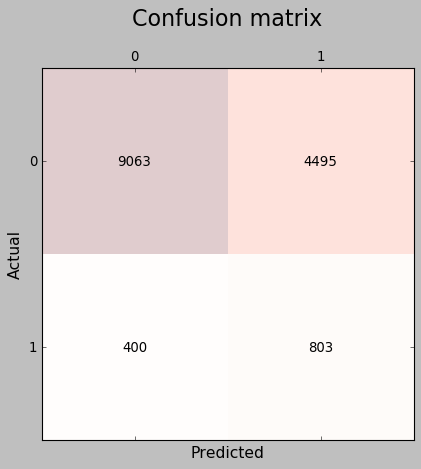

In [21]:
second_stack_probs = second_stack.predict_proba(first_stack.transform(X_test_set))
second_stack_preds = second_stack.predict(first_stack.transform(X_test_set))
conf_mat = confusion_matrix(y_test_set, second_stack_preds)
# Define figure size and figure ratios
plt.figure(figsize=(16, 8))
plt.matshow(conf_mat, cmap=plt.cm.Reds, alpha=0.2)
for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=conf_mat[i, j], ha="center", va="center")
plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14});

### Selanjutnya kita cek partial dependence untuk menentukan fitur mana yang paling penting dalam model ini dan hubungannya dengan kemungkinan client yang telat membayar.

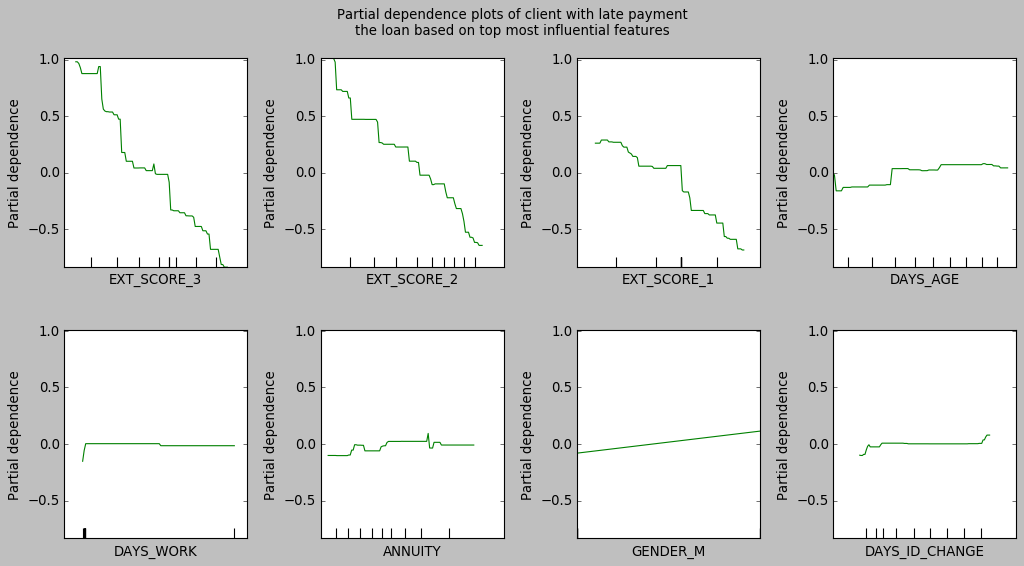

In [24]:
import warnings
warnings.filterwarnings('ignore')

# Plot partial dependence plots
gbrt = GradientBoostingClassifier(loss="deviance",
                                  learning_rate=0.1,
                                  n_estimators=100,
                                  max_depth=3,
                                  random_state=123)
gbrt.fit(X_res, y_res)
fig, axes = plot_partial_dependence(gbrt, X_res,
                                    np.argsort(gbrt.feature_importances_)[::-1][:8],
                                    n_cols=4,
                                    feature_names=df_dummies.columns[1:-12],
                                    figsize=(14, 8))
plt.subplots_adjust(top=0.9)
plt.suptitle("Partial dependence plots of client with late payment\n"
             "the loan based on top most influential features")
for ax in axes: ax.set_xticks(())
for ax in [axes[0], axes[4]]: ax.set_ylabel("Partial dependence")